In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# PREPROCESSING
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# MODELS
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

# CV
from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# METRICS
from sklearn.metrics import r2_score, mean_absolute_percentage_error, root_mean_squared_error

# DON'T USE SCIENTIFIC NOTATION
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
RANDOM_STATE = 42

# Data

In [3]:
df = pd.read_csv('Knn Imputed/North Ave.csv', index_col='Date_Time')
df.index = pd.to_datetime(df.index)
df.drop(columns=['Station_Name'], inplace=True)
df = df.astype('uint16')
df

Entry  Year  Month  Day  Hour  Weekday  Is_Holiday
Date_Time                                                              
2022-04-18 04:00:00    566  2022      4   18     4        1           0
2022-04-18 05:00:00   2508  2022      4   18     5        1           0
2022-04-18 06:00:00   2889  2022      4   18     6        1           0
2022-04-18 07:00:00   2607  2022      4   18     7        1           0
2022-04-18 08:00:00   2269  2022      4   18     8        1           0
...                    ...   ...    ...  ...   ...      ...         ...
2023-12-31 19:00:00    334  2023     12   31    19        7           1
2023-12-31 20:00:00      0  2023     12   31    20        7           1
2023-12-31 21:00:00      0  2023     12   31    21        7           1
2023-12-31 22:00:00      0  2023     12   31    22        7           1
2023-12-31 23:00:00      0  2023     12   31    23        7           1

[12460 rows x 7 columns]

# Splitting

In [4]:
TRAIN_SIZE = 0.8
SPLIT_INDEX = int(TRAIN_SIZE * len(df.index))

In [5]:
tss = TimeSeriesSplit(n_splits=10)

In [6]:
def create_Lag_Features():
    output = df.copy()
    output['Entry Last Hour'] = output['Entry'].diff(1)
    output['Entry Last 2 Hours'] = output['Entry'].diff(2)
    output['Entry Yesterday'] = output['Entry'].diff(20)
    output['Entry Last Week'] = output['Entry'].diff(20*7)
    output.dropna(inplace=True)

    SPLIT_INDEX = int(TRAIN_SIZE * len(output.index))

    lag_train = output[:SPLIT_INDEX]
    lag_test = output[SPLIT_INDEX:]

    X_train_lag = lag_train.drop(columns=['Entry'])
    X_test_lag = lag_test.drop(columns=['Entry'])
    y_train_lag = lag_train['Entry']
    y_test_lag = lag_test['Entry']

    return X_train_lag, X_test_lag, y_train_lag, y_test_lag

In [7]:
train = df[:SPLIT_INDEX]
test = df[SPLIT_INDEX:]

X_train = train.drop(columns=['Entry'])
X_test = test.drop(columns=['Entry'])
y_train = train['Entry']
y_test = test['Entry']

print('X_train\t:', X_train.shape)
print('X_test\t:', X_test.shape)
print('y_train\t:', y_train.shape)
print('y_test\t:', y_test.shape)

X_train	: (9968, 6)
X_test	: (2492, 6)
y_train	: (9968,)
y_test	: (2492,)


### Results storage

In [8]:
df_predictions_train = pd.DataFrame(y_train)
df_predictions_test = pd.DataFrame(y_test)
df_scores = pd.DataFrame(columns=['Train R2', 'Test R2', 
                                  'Train MAPE', 'Test MAPE',
                                  'Train RMSE', 'Test RMSE',
                                  'Best Params'
                                 ])

### Helper Functions for Results Storing

In [9]:
def call_predict(model, type):
    df_predictions_train[type] = model.predict(X_train)
    df_predictions_test[type] = model.predict(X_test)

def get_score(type, best_params, train_correct = None, test_correct = None, train_predict=None, test_predict=None):
    if train_correct is None:
        train_correct = y_train
        test_correct = y_test
        train_predict = df_predictions_train[type]
        test_predict = df_predictions_test[type]
    
    df_scores.loc[type] = [
        r2_score(train_correct, train_predict),
        r2_score(test_correct, test_predict),
        mean_absolute_percentage_error(train_correct, train_predict),
        mean_absolute_percentage_error(test_correct, test_predict),
        root_mean_squared_error(train_correct, train_predict),
        root_mean_squared_error(test_correct, test_predict),
        best_params
    ]

    return df_scores

def plot_predictions(df, title, cols=['Entry'], LIMIT=100):
    df[cols][:LIMIT].plot()
    plt.title(title)
    plt.show()

In [10]:
def summarize(model, model_name, best_params):
    call_predict(model, model_name)
    plot_predictions(df_predictions_test, model_name + ' Test Predictions', ['Entry', model_name])
    return get_score(model_name, best_params)

# 1. KNN
KnnRegressor makes predictions based on the mean of the values of the closest n neighbors. 

GridSearch will be used since it's only one hyperparameter that we're iterating through.
<br>Start at 2, since 1 neighbor is an obvious overfit.

In addition, use a pipeline to add a scaler preprocessing since Knn's distance measure will be affected by different ranges.

We can do a comparison to check their difference with and without scaling.

In [11]:
params_Knn = {'n_neighbors' : range(2, 20)}

cv_Knn = GridSearchCV(KNeighborsRegressor(n_jobs=-1), 
                      params_Knn, 
                      scoring='r2', 
                      cv=tss)
cv_Knn.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=KNeighborsRegressor(n_jobs=-1),
             param_grid={'n_neighbors': range(2, 20)}, scoring='r2')

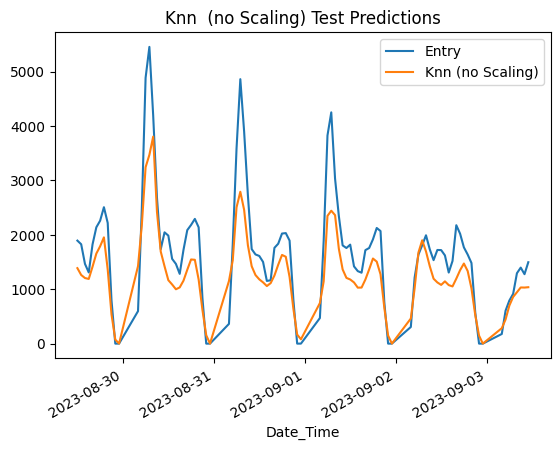

In [12]:
call_predict(cv_Knn.best_estimator_, 'Knn (no Scaling)')
plot_predictions(df_predictions_test, 'Knn  (no Scaling) Test Predictions', ['Entry', 'Knn (no Scaling)'])

In [13]:
get_score('Knn (no Scaling)', cv_Knn.best_params_)

Train R2  Test R2            Train MAPE  \
Knn (no Scaling)     0.929    0.590 39949115434563272.000   

                             Test MAPE  Train RMSE  Test RMSE  \
Knn (no Scaling) 48524237798890728.000     231.210    730.227   

                         Best Params  
Knn (no Scaling)  {'n_neighbors': 6}

### Knn Results
Knn is quite remarkable for a lazy learner.
<br>It captures the differing rises and falls unique to each different day.

However it's certainly overfit with testing errors being signifcantly higher.

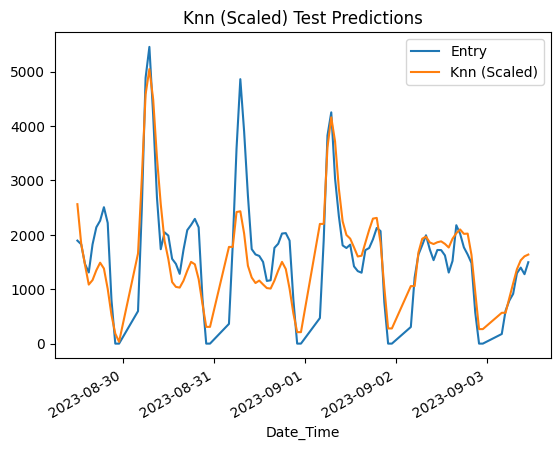

Train R2  Test R2            Train MAPE  \
Knn (no Scaling)     0.929    0.590 39949115434563272.000   
Knn (Scaled)         0.894    0.726 74845386062481680.000   

                             Test MAPE  Train RMSE  Test RMSE  \
Knn (no Scaling) 48524237798890728.000     231.210    730.227   
Knn (Scaled)     93246078480611520.000     282.559    596.902   

                                Best Params  
Knn (no Scaling)         {'n_neighbors': 6}  
Knn (Scaled)      {'model__n_neighbors': 3}

In [14]:
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsRegressor())
])

params_knn = {
    'model__n_neighbors' : range(2, 20)
}
cv_knn = GridSearchCV(pipe_knn, params_knn, scoring='r2')
cv_knn.fit(X_train, y_train)

summarize(cv_knn, 'Knn (Scaled)', cv_knn.best_params_)

There is a significant difference in performance when scaling.

The test set predictions have increased in score, while the overfitting is also decreased.

# 2. Polynomial Regression Models
Considering that we have a daily seasonal pattern occuring every 20 hours, it might be possible to capture this behavior with a polynomial curve.

We could try the basic linear regression and loss adjusting SGDRegressor.

## 2.1 Linear Regression 
The linear lines unfortunately seem too simple. There's also not very much tweaking we can do with the hyperparamters.

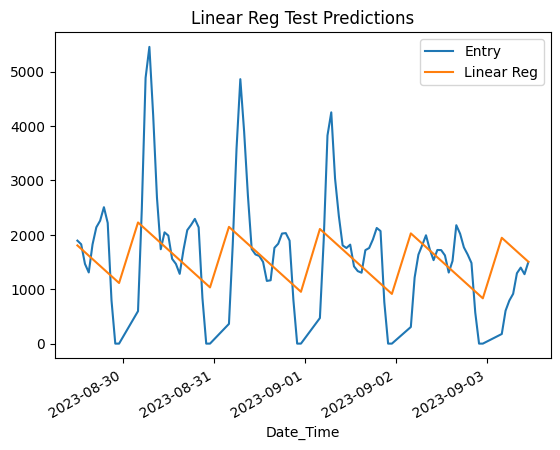

Train R2  Test R2             Train MAPE  \
Knn (no Scaling)     0.929    0.590  39949115434563272.000   
Knn (Scaled)         0.894    0.726  74845386062481680.000   
Linear Reg           0.234    0.186 360850221942044416.000   

                              Test MAPE  Train RMSE  Test RMSE  \
Knn (no Scaling)  48524237798890728.000     231.210    730.227   
Knn (Scaled)      93246078480611520.000     282.559    596.902   
Linear Reg       409626207723478528.000     759.156   1029.203   

                                                        Best Params  
Knn (no Scaling)                                 {'n_neighbors': 6}  
Knn (Scaled)                              {'model__n_neighbors': 3}  
Linear Reg        {'copy_X': True, 'fit_intercept': True, 'n_job...

In [15]:
model_Linear = LinearRegression(n_jobs=-1)
model_Linear.fit(X_train, y_train)

summarize(model_Linear, 'Linear Reg', model_Linear.get_params())

## 2.2 Stochastic Gradient Descent
SGD is able to provide us a curve improved with a loss function.

However it's extemely difficult to fine tune the hyperparameters often ranging in the decimals.

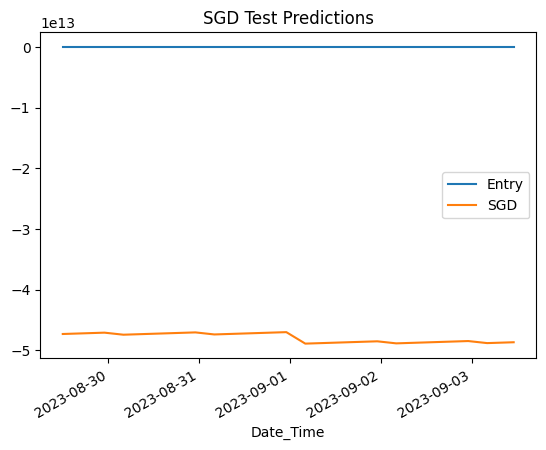

Train R2                     Test R2  \
Knn (no Scaling)                       0.929                       0.590   
Knn (Scaled)                           0.894                       0.726   
Linear Reg                             0.234                       0.186   
SGD              -3048816939203301998592.000 -1769755200076171706368.000   

                                        Train MAPE  \
Knn (no Scaling)             39949115434563272.000   
Knn (Scaled)                 74845386062481680.000   
Linear Reg                  360850221942044416.000   
SGD              19958875337919737538191294464.000   

                                         Test MAPE         Train RMSE  \
Knn (no Scaling)             48524237798890728.000            231.210   
Knn (Scaled)                 93246078480611520.000            282.559   
Linear Reg                  409626207723478528.000            759.156   
SGD              19539216271570149584603709440.000 47888074282457.539   

                          Test RMSE  \
Knn (no Scaling)            730.227   
Knn (Scaled)                596.902   
Linear Reg                 1029.203   
SGD              47997109942805.375   

                                                        Best Params  
Knn (no Scaling)                                 {'n_neighbors': 6}  
Knn (Scaled)                              {'model__n_neighbors': 3}  
Linear Reg        {'copy_X': True, 'fit_intercept': True, 'n_job...  
SGD               {'tol': 0.1, 'eta0': 0.001, 'epsilon': 0.1, 'a...

In [16]:
params_SGD = {
    'alpha' : np.arange(0.0001, 1, 0.001),
    'tol' : [0.1, 0.01, 0.001],
    'eta0' : [0.1, 0.01, 0.001],
    'epsilon' : [0.1, 0.01, 0.001]
}

cv_SGD = RandomizedSearchCV(SGDRegressor(random_state=RANDOM_STATE), params_SGD, cv=tss, scoring='r2', n_jobs=-1)
cv_SGD.fit(X_train, y_train)

summarize(cv_SGD.best_estimator_, 'SGD', cv_SGD.best_params_)

### The most impressive model so far has been Knn

Let's try BlackBox models to see if we can get better results.

Our linear regressors just don't appear complex enough to capture the 20 hour seasons.

# 3. Random Forest
Each individual tree has a chance of overfitting unless controlled by the hyperparameters.

This may be exactly what we want since the previous polynomial regressors were too basic, while our Knn seems to perform well when averaging with only from a few neighbors.

No more scaling, since trees are scale invariant.

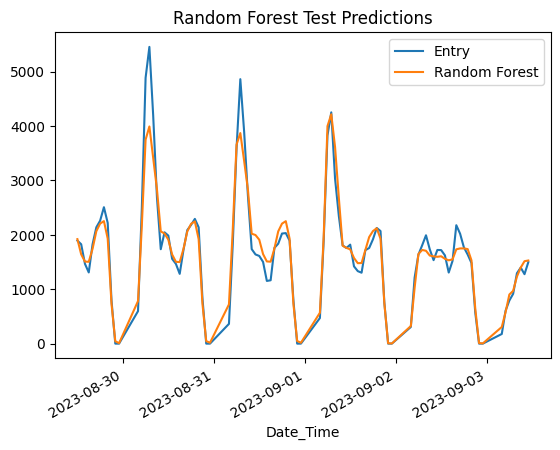

Train R2                     Test R2  \
Knn (no Scaling)                       0.929                       0.590   
Knn (Scaled)                           0.894                       0.726   
Linear Reg                             0.234                       0.186   
SGD              -3048816939203301998592.000 -1769755200076171706368.000   
Random Forest                          0.925                       0.853   

                                        Train MAPE  \
Knn (no Scaling)             39949115434563272.000   
Knn (Scaled)                 74845386062481680.000   
Linear Reg                  360850221942044416.000   
SGD              19958875337919737538191294464.000   
Random Forest                38799198259266720.000   

                                         Test MAPE         Train RMSE  \
Knn (no Scaling)             48524237798890728.000            231.210   
Knn (Scaled)                 93246078480611520.000            282.559   
Linear Reg                  409626207723478528.000            759.156   
SGD              19539216271570149584603709440.000 47888074282457.539   
Random Forest                19108315117594268.000            237.564   

                          Test RMSE  \
Knn (no Scaling)            730.227   
Knn (Scaled)                596.902   
Linear Reg                 1029.203   
SGD              47997109942805.375   
Random Forest               437.582   

                                                        Best Params  
Knn (no Scaling)                                 {'n_neighbors': 6}  
Knn (Scaled)                              {'model__n_neighbors': 3}  
Linear Reg        {'copy_X': True, 'fit_intercept': True, 'n_job...  
SGD               {'tol': 0.1, 'eta0': 0.001, 'epsilon': 0.1, 'a...  
Random Forest     {'n_estimators': 100, 'min_samples_split': 0.0...

In [17]:
params_rf = {
    'max_depth' : range(3, 18),
    'max_features' : range(2, 5),
    'n_estimators' : range(100, 300, 50),
    'min_samples_split' : np.arange(0.0001, 0.001, 0.0001),
    'min_samples_leaf' : np.arange(0.0001, 0.001, 0.0001)
}

cv_rf = RandomizedSearchCV(RandomForestRegressor(random_state=RANDOM_STATE), params_rf, cv=tss, scoring='r2', random_state=RANDOM_STATE, n_jobs=-1, n_iter=20)
cv_rf.fit(X_train, y_train)

summarize(cv_rf.best_estimator_, 'Random Forest', cv_rf.best_params_)

### Lag Features
Lag refers to the relation to a previous time period.

We create the features and check its affect.

In [18]:
X_train_lag, X_test_lag, y_train_lag, y_test_lag = create_Lag_Features()

cv_rf.fit(X_train_lag, y_train_lag)
# summarize(cv_rf, 'Random Forest w/ Lag', cv_rf.best_params_, True)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
                   estimator=RandomForestRegressor(random_state=42), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': range(3, 18),
                                        'max_features': range(2, 5),
                                        'min_samples_leaf': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                                        'min_samples_split': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                                        'n_estimators': range(100, 300, 50)},
                   random_state=42, scoring='r2')

In [19]:
df_predictions_train_lag = y_train_lag.copy()
df_predictions_test_lag = y_test_lag.copy()

In [20]:
df_predictions_train_lag['RF'] = cv_rf.predict(X_train_lag)
df_predictions_test_lag['RF'] = cv_rf.predict(X_test_lag)

In [22]:
get_score('Random Forest w/ Lag', cv_rf.best_params_, 
          y_train_lag,
          y_test_lag,
          df_predictions_train_lag['RF'], 
          df_predictions_test_lag['RF'],
         )

Train R2                     Test R2  \
Knn (no Scaling)                           0.929                       0.590   
Knn (Scaled)                               0.894                       0.726   
Linear Reg                                 0.234                       0.186   
SGD                  -3048816939203301998592.000 -1769755200076171706368.000   
Random Forest                              0.925                       0.853   
Random Forest w/ Lag                       0.979                       0.893   

                                            Train MAPE  \
Knn (no Scaling)                 39949115434563272.000   
Knn (Scaled)                     74845386062481680.000   
Linear Reg                      360850221942044416.000   
SGD                  19958875337919737538191294464.000   
Random Forest                    38799198259266720.000   
Random Forest w/ Lag              5828501523904949.000   

                                             Test MAPE         Train RMSE  \
Knn (no Scaling)                 48524237798890728.000            231.210   
Knn (Scaled)                     93246078480611520.000            282.559   
Linear Reg                      409626207723478528.000            759.156   
SGD                  19539216271570149584603709440.000 47888074282457.539   
Random Forest                    19108315117594268.000            237.564   
Random Forest w/ Lag             16028820935110114.000            125.518   

                              Test RMSE  \
Knn (no Scaling)                730.227   
Knn (Scaled)                    596.902   
Linear Reg                     1029.203   
SGD                  47997109942805.375   
Random Forest                   437.582   
Random Forest w/ Lag            373.621   

                                                            Best Params  
Knn (no Scaling)                                     {'n_neighbors': 6}  
Knn (Scaled)                                  {'model__n_neighbors': 3}  
Linear Reg            {'copy_X': True, 'fit_intercept': True, 'n_job...  
SGD                   {'tol': 0.1, 'eta0': 0.001, 'epsilon': 0.1, 'a...  
Random Forest         {'n_estimators': 100, 'min_samples_split': 0.0...  
Random Forest w/ Lag  {'n_estimators': 250, 'min_samples_split': 0.0...

# 4. XGB
XGB is a gradient boosting forest that improves upon last iterations.

We'll be using a CV to compare whether the regular features or the one with lag features produce better results.

### Cross Validation for XGBoost

In [23]:
def XGB_cv(X_train, y_train):
    scores = []    
    for train_index, val_index in tss.split(y_train):
        
        model_XGB.fit(X_train.iloc[train_index], y_train.iloc[train_index],
                 eval_set=[(X_train.iloc[train_index], y_train.iloc[train_index]), (X_train.iloc[val_index], y_train.iloc[val_index])],
                     verbose=100)
        scores.append(
            r2_score(model_XGB.predict(X_train.iloc[val_index]),
                     y_train.iloc[val_index]
                    ))
    
    print('Crosss validation score R2: ', np.mean(scores))

In [24]:
model_XGB = xgb.XGBRegressor(n_estimators=500, early_stopping_rounds=50, random_state=RANDOM_STATE, eval_metric='rmse')

XGB_cv(X_train, y_train)

[0]	validation_0-rmse:580.98553	validation_1-rmse:629.67300
[58]	validation_0-rmse:38.93769	validation_1-rmse:288.26584
[0]	validation_0-rmse:593.12012	validation_1-rmse:590.01408
[100]	validation_0-rmse:39.82593	validation_1-rmse:248.92836
[104]	validation_0-rmse:39.00242	validation_1-rmse:249.27362
[0]	validation_0-rmse:588.49262	validation_1-rmse:588.25963
[81]	validation_0-rmse:56.85626	validation_1-rmse:179.82380
[0]	validation_0-rmse:585.93273	validation_1-rmse:751.26218
[87]	validation_0-rmse:58.89243	validation_1-rmse:490.81094
[0]	validation_0-rmse:616.36419	validation_1-rmse:646.79052
[53]	validation_0-rmse:84.77633	validation_1-rmse:571.58207
[0]	validation_0-rmse:621.53034	validation_1-rmse:602.51585
[56]	validation_0-rmse:99.18464	validation_1-rmse:461.16788
[0]	validation_0-rmse:621.29768	validation_1-rmse:794.79731
[90]	validation_0-rmse:90.63801	validation_1-rmse:564.47680
[0]	validation_0-rmse:645.21101	validation_1-rmse:571.34487
[54]	validation_0-rmse:121.39227	valid

In [25]:
XGB_cv(X_train_lag, y_train_lag)

[0]	validation_0-rmse:587.21508	validation_1-rmse:620.52445
[98]	validation_0-rmse:3.93270	validation_1-rmse:224.20977
[0]	validation_0-rmse:597.95698	validation_1-rmse:598.05941
[100]	validation_0-rmse:10.13028	validation_1-rmse:163.58550
[109]	validation_0-rmse:8.69022	validation_1-rmse:163.73428
[0]	validation_0-rmse:589.96974	validation_1-rmse:588.95688
[100]	validation_0-rmse:15.54576	validation_1-rmse:112.67549
[200]	validation_0-rmse:5.15675	validation_1-rmse:112.40136
[206]	validation_0-rmse:4.74211	validation_1-rmse:112.44718
[0]	validation_0-rmse:587.73623	validation_1-rmse:741.58755
[70]	validation_0-rmse:26.10378	validation_1-rmse:446.15033
[0]	validation_0-rmse:618.59486	validation_1-rmse:623.32374
[60]	validation_0-rmse:39.98793	validation_1-rmse:393.40267
[0]	validation_0-rmse:618.92741	validation_1-rmse:640.11697
[85]	validation_0-rmse:40.53157	validation_1-rmse:300.20354
[0]	validation_0-rmse:623.87968	validation_1-rmse:774.27461
[73]	validation_0-rmse:51.50951	validat

In [26]:
model_XGB.fit(X_train_lag, y_train_lag, 
              eval_set=[(X_train_lag, y_train_lag), (X_test_lag, y_test_lag)])
# summarize(model_XGB, 'XGB', model_XGB.get_params())

df_predictions_train_lag['XGB'] = model_XGB.predict(X_train_lag)
df_predictions_test_lag['XGB'] = model_XGB.predict(X_test_lag)

get_score('XGB w/ Lag', model_XGB.get_params(), 
          y_train_lag,
          y_test_lag,
          df_predictions_train_lag['XGB'], 
          df_predictions_test_lag['XGB'],
         )

[0]	validation_0-rmse:669.43334	validation_1-rmse:999.23207
[1]	validation_0-rmse:531.72792	validation_1-rmse:863.92762
[2]	validation_0-rmse:438.44278	validation_1-rmse:787.56188
[3]	validation_0-rmse:380.08849	validation_1-rmse:711.57362
[4]	validation_0-rmse:336.70049	validation_1-rmse:670.46640
[5]	validation_0-rmse:306.69807	validation_1-rmse:606.61716
[6]	validation_0-rmse:282.60155	validation_1-rmse:577.22825
[7]	validation_0-rmse:266.53127	validation_1-rmse:552.38292
[8]	validation_0-rmse:253.97240	validation_1-rmse:536.30817
[9]	validation_0-rmse:230.00186	validation_1-rmse:472.05591
[10]	validation_0-rmse:209.27409	validation_1-rmse:425.09184
[11]	validation_0-rmse:198.96749	validation_1-rmse:414.30095
[12]	validation_0-rmse:184.86927	validation_1-rmse:387.86457
[13]	validation_0-rmse:178.64039	validation_1-rmse:381.80240
[14]	validation_0-rmse:171.21263	validation_1-rmse:367.31087
[15]	validation_0-rmse:164.69241	validation_1-rmse:351.89353
[16]	validation_0-rmse:157.01516	v

Train R2                     Test R2  \
Knn (no Scaling)                           0.929                       0.590   
Knn (Scaled)                               0.894                       0.726   
Linear Reg                                 0.234                       0.186   
SGD                  -3048816939203301998592.000 -1769755200076171706368.000   
Random Forest                              0.925                       0.853   
Random Forest w/ Lag                       0.979                       0.893   
XGB w/ Lag                                 0.991                       0.925   

                                            Train MAPE  \
Knn (no Scaling)                 39949115434563272.000   
Knn (Scaled)                     74845386062481680.000   
Linear Reg                      360850221942044416.000   
SGD                  19958875337919737538191294464.000   
Random Forest                    38799198259266720.000   
Random Forest w/ Lag              5828501523904949.000   
XGB w/ Lag                        9508170629712378.000   

                                             Test MAPE         Train RMSE  \
Knn (no Scaling)                 48524237798890728.000            231.210   
Knn (Scaled)                     93246078480611520.000            282.559   
Linear Reg                      409626207723478528.000            759.156   
SGD                  19539216271570149584603709440.000 47888074282457.539   
Random Forest                    19108315117594268.000            237.564   
Random Forest w/ Lag             16028820935110114.000            125.518   
XGB w/ Lag                       23549041215343096.000             81.719   

                              Test RMSE  \
Knn (no Scaling)                730.227   
Knn (Scaled)                    596.902   
Linear Reg                     1029.203   
SGD                  47997109942805.375   
Random Forest                   437.582   
Random Forest w/ Lag            373.621   
XGB w/ Lag                      312.396   

                                                            Best Params  
Knn (no Scaling)                                     {'n_neighbors': 6}  
Knn (Scaled)                                  {'model__n_neighbors': 3}  
Linear Reg            {'copy_X': True, 'fit_intercept': True, 'n_job...  
SGD                   {'tol': 0.1, 'eta0': 0.001, 'epsilon': 0.1, 'a...  
Random Forest         {'n_estimators': 100, 'min_samples_split': 0.0...  
Random Forest w/ Lag  {'n_estimators': 250, 'min_samples_split': 0.0...  
XGB w/ Lag            {'objective': 'reg:squarederror', 'base_score'...